In [1]:
#Importing requird libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#reading the words
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
#Building vocab
chars = sorted(list(set(''.join(words))))
stoi  = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
#Building the dataset
block_size = 3
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [8]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [9]:
#Building train, dev/validation, test data
def build_dataset(words):
    #Building the dataset
    block_size = 3
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"{X.shape}, {Y.shape}")
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182441, 3]), torch.Size([182441])
torch.Size([22902, 3]), torch.Size([22902])
torch.Size([22803, 3]), torch.Size([22803])


In [6]:
#Embeddings
c = torch.randn((27,2))
emb = c[X]
emb.shape

torch.Size([32, 3, 2])

In [7]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [8]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)

In [9]:
h.shape

torch.Size([32, 100])

In [10]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [11]:
logits = h @ W2 + b2

In [12]:
logits.shape

torch.Size([32, 27])

In [13]:
counts = logits.exp()

In [14]:
prob = counts / counts.sum(1, keepdims=True)

In [15]:
prob.shape

torch.Size([32, 27])

In [16]:
prob[0].sum()

tensor(1.0000)

In [21]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.5140)

In [ ]:
##Implementing

In [76]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [32]:
#Parameters
g = torch.Generator().manual_seed(442) # for reproducibility
C = torch.randn((27,10), generator = g)
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [33]:
sum(p.nelement() for p in parameters) #total number of parameters

11897

In [34]:
for p in parameters:
    p.requires_grad = True

In [15]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [35]:
lri = []
lossi = []
stepi = []

In [36]:
for i in range(50000):
    #minibatch construct
    ix = torch.randint(0, X_train.shape[0], (32,))
    
    #Forward pass
    emb = C[X_train[ix]] #32,3,2
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32, 100
    logits = h@ W2 + b2
    loss = F.cross_entropy(logits, y_train[ix])
    #print(loss.item())
    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #Update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
#print(loss.item())

In [29]:
emb = C[X_dev] #32,3,2
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # 32, 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
loss

tensor(2.5355, grad_fn=<NllLossBackward0>)

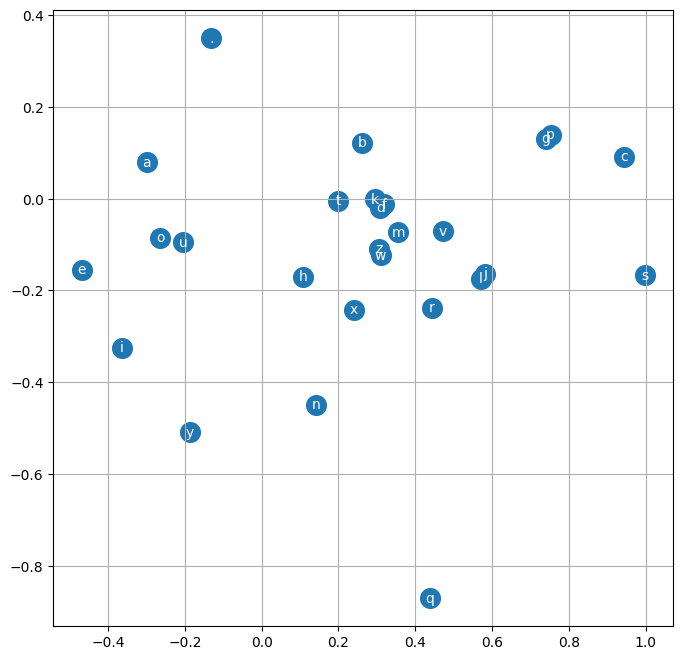

In [30]:
#Visualizing the embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor');
             

In [43]:
#Sample from the model
g = torch.Generator().manual_seed(442)
for _ in range(20):
    out = []
    context = [0] * block_size #Initializing step
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32, 100
        logits = h@ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break
            
    print(''.join(itos[i] for i in out))
        

eushawvoru.
jero.
bro.
ana.
yellasmyrienia.
suma.
deyus.
takellismon.
kaysiaha.
jael.
doleyser.
zeoseuntyah.
wianny.
aden.
gab.
panhah.
cayden.
alayrincele.
vah.
jaley.


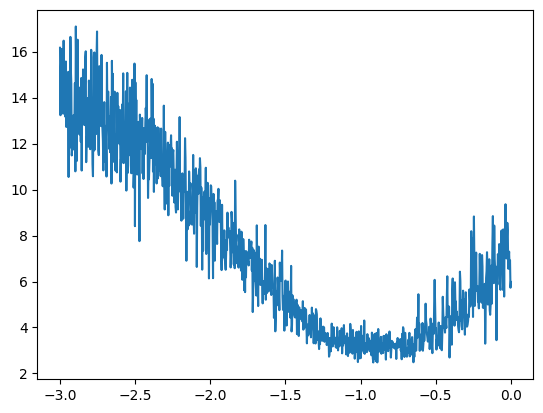

In [83]:
plt.plot(lri, lossi);